In [1]:
import pickle
import numpy as np
import pandas as pd
#import gensim
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, BatchNormalization, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
#from plot_model import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14369389842794108189,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1654237252832456511
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9923680666
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5395515177245528659
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10988499764
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
     l

In [2]:
print(len(tf.config.experimental.list_physical_devices("GPU")))

4


In [4]:
pd.set_option('display.max_colwidth', 140)

tweets_text = pd.read_csv("dataset_improved_260321.txt", sep='\t', header=None)
tweets_text.columns = ['Text','Label']

print("Out of {} rows, {} are spams, {} are non-spams".format(len(tweets_text),
                                                              len(tweets_text[tweets_text['Label']=='Spam']),
                                                              len(tweets_text[tweets_text['Label']=='Ham'])))

Out of 3938859 rows, 1688741 are spams, 2250118 are non-spams


In [5]:
tweets_text.isnull().sum()

Text     0
Label    0
dtype: int64

In [6]:
# Convert labels to numeric format
tweets_text['Label'] = np.where(tweets_text['Label']=='Spam',1,0)

X_train, X_test, y_train, y_test = train_test_split(tweets_text['Text'], tweets_text['Label'], 
                                                    test_size=0.01, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.010101, random_state=2)

In [7]:
# Convert labels to numpy arrays
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [8]:
print("Training data: {} ({}%)\nTest data: {} ({}%)\nValidation data: {} ({}%)".format(len(X_train), round((len(X_train)/len(tweets_text))*100), 
                                                                                       len(X_test), round((len(X_test)/len(tweets_text))*100), 
                                                                                       len(X_val), round((len(X_val)/len(tweets_text))*100)))

Training data: 3860081 (98%)
Test data: 39389 (1%)
Validation data: 39389 (1%)


# Start of Word2Vec

In [31]:
# Only for training word2vec model
tweets_text["Tokenized_Text"] = tweets_text["Text"].str.split(" ")
tweets_text['Label'] = np.where(tweets_text['Label']=='Spam',1,0)
tweets_text.head()

,Text,Label,Tokenized_Text
0,house party daybreak weird feared,0,"[house, party, daybreak, weird, feared]"
1,salt lake city international url,0,"[salt, lake, city, international, url]"
2,almost home international url,0,"[almost, home, international, url]"
3,lunch url,0,"[lunch, url]"
4,book usermention url,0,"[book, usermention, url]"


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets_text['Text'], tweets_text['Label'], 
                                                    test_size=0.01, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.010101, random_state=2)

In [33]:
# Convert labels to numpy arrays
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

print("Training data: {} ({}%)\nTest data: {} ({}%)\nValidation data: {} ({}%)".format(len(X_train), round((len(X_train)/len(tweets_text))*100), 
                                                                                       len(X_test), round((len(X_test)/len(tweets_text))*100), 
                                                                                       len(X_val), round((len(X_val)/len(tweets_text))*100)))

Training data: 3897636 (98%)
Test data: 39772 (1%)
Validation data: 39772 (1%)


In [17]:
def word2vec_embed(train_data, dim=50):
    # Train a basic word2vec model
    #w2v_model = gensim.models.Word2Vec(train_data, size=dim, window=5, min_count=1, seed=14) #cbow
    w2v_model = gensim.models.Word2Vec(train_data, size=dim, sg=1, window=10, min_count=1, seed=14) #skipgram
    #generate a list of words the word2vec model learned work vectors for, words that fulfill min_count condition
    print("Number of words learned: {}".format(len(w2v_model.wv.index2word)))
    print("List of words are: ", w2v_model.wv.index2word)
    
    return w2v_model

In [11]:
w2v_model = word2vec_embed(X_train)

# Save trained cbow word2vec model
with open('w2v_model.pickle', 'wb') as saved_model:
    pickle.dump(w2v_model, saved_model, protocol=pickle.HIGHEST_PROTOCOL)

Number of words learned: 27
List of words are:  [' ', 'e', 't', 'n', 'r', 'a', 'o', 'i', 's', 'l', 'u', 'm', 'h', 'g', 'c', 'd', 'p', 'w', 'y', 'k', 'b', 'f', 'v', 'x', 'j', 'z', 'q']


In [34]:
# Load trained cbow word2vec model
with open('w2v_model.pickle', 'rb') as saved_model:
    w2v_model = pickle.load(saved_model)

In [18]:
w2v_model = word2vec_embed(X_train)

# Save trained skipgram word2vec model
with open('w2v_model_skipgram.pickle', 'wb') as saved_model:
    pickle.dump(w2v_model, saved_model, protocol=pickle.HIGHEST_PROTOCOL)

Number of words learned: 44866
List of words are:  ['usermention', 'url', 'hashtag', 'retweet', 'new', 'get', 'like', 'day', 'good', 'love', 'time', 'one', 'got', 'make', 'know', 'twitter', 'free', 'today', 'video', 'need', 'want', 'see', 'great', 'think', 'back', 'work', 'going', 'home', 'best', 'people', 'post', 'way', 'say', 'news', 'really', 'thanks', 'right', 'look', 'check', 'life', 'year', 'would', 'money', 'thing', 'night', 'show', 'come', 'game', 'well', 'take', 'live', 'still', 'world', 'much', 'man', 'business', 'follow', 'marketing', 'let', 'week', 'last', 'first', 'help', 'please', 'tweet', 'happy', 'via', 'friend', 'better', 'feel', 'never', 'girl', 'find', 'tonight', 'tip', 'watch', 'hope', 'guy', 'big', 'morning', 'could', 'real', 'next', 'getting', 'yes', 'music', 'site', 'even', 'para', 'movie', 'hey', 'start', 'top', 'win', 'job', 'bad', 'gon', 'use', 'update', 'tomorrow', 'ever', 'looking', 'give', 'song', 'keep', 'wait', 'hour', 'die', 'nice', 'always', 'social', '

In [7]:
# Load trained skipgram word2vec model
with open('w2v_model_skipgram.pickle', 'rb') as saved_model:
    w2v_model = pickle.load(saved_model)

In [35]:
w2v_weights = w2v_model.wv.syn0
print(w2v_weights.shape)

(44866, 50)


/home/students/acct1001_11/anaconda3/envs/pythongpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [36]:
w2v_weights[8]

array([-4.3403983 ,  0.40556964, -0.42501146,  1.4730797 ,  0.90421176,
        1.9075869 ,  0.08312437,  0.6439833 ,  2.5651932 ,  1.1874664 ,
       -1.0775348 , -2.8239334 ,  0.84565836, -0.9035908 , -1.4741738 ,
       -0.38576716,  0.03499779, -2.1147017 ,  0.85776967, -0.7507164 ,
        1.3248456 ,  0.8495753 ,  2.4046419 ,  1.4829855 ,  0.32771957,
        0.30922318,  0.6828054 , -1.3220766 , -1.3955446 ,  1.2230927 ,
       -0.46347642, -1.7479054 , -0.997003  , -1.7799075 ,  4.8689637 ,
        0.45992202, -2.0903652 ,  1.3692051 , -0.07983781,  1.9820805 ,
        2.676074  , -0.42747968, -0.3554965 ,  0.7534638 ,  1.4256805 ,
        0.11117712, -0.15307929, -2.5963352 , -0.25292033, -1.0869105 ],
      dtype=float32)

In [13]:
# Train the tokenizer and use that tokenizer to convert sentences into sequences of numbers
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)
print("Number of vocabulary: {}".format(len(tokenizer.word_index)))
print(tokenizer.word_index)

Number of vocabulary: 44866
{'usermention': 1, 'url': 2, 'hashtag': 3, 'retweet': 4, 'new': 5, 'get': 6, 'like': 7, 'day': 8, 'good': 9, 'love': 10, 'time': 11, 'one': 12, 'got': 13, 'make': 14, 'know': 15, 'twitter': 16, 'free': 17, 'today': 18, 'video': 19, 'need': 20, 'want': 21, 'see': 22, 'great': 23, 'think': 24, 'back': 25, 'work': 26, 'going': 27, 'home': 28, 'best': 29, 'people': 30, 'post': 31, 'way': 32, 'say': 33, 'news': 34, 'really': 35, 'thanks': 36, 'right': 37, 'look': 38, 'check': 39, 'life': 40, 'year': 41, 'would': 42, 'money': 43, 'thing': 44, 'night': 45, 'show': 46, 'come': 47, 'game': 48, 'well': 49, 'take': 50, 'live': 51, 'still': 52, 'world': 53, 'much': 54, 'man': 55, 'business': 56, 'follow': 57, 'marketing': 58, 'let': 59, 'week': 60, 'last': 61, 'first': 62, 'help': 63, 'please': 64, 'tweet': 65, 'happy': 66, 'via': 67, 'friend': 68, 'better': 69, 'feel': 70, 'never': 71, 'girl': 72, 'find': 73, 'tonight': 74, 'tip': 75, 'watch': 76, 'hope': 77, 'guy': 78

In [14]:
with open('tokenizer_improved_noOOV.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
#Load the tokenizer
with open('tokenizer_improved_noOOV.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

print("Number of vocabulary: {}".format(len(tokenizer.word_index)))

Number of vocabulary: 44866


# End of Word2Vec

In [8]:
# Train the tokenizer and use that tokenizer to convert sentences into sequences of numbers
tokenizer = Tokenizer(oov_token='<OOV>', filters='')
tokenizer.fit_on_texts(X_train)
print("Number of vocabulary: {}".format(len(tokenizer.word_index)))
print(tokenizer.word_index)

Number of vocabulary: 41746
{'<OOV>': 1, 'usermention': 2, 'url': 3, 'retweet': 4, 'get': 5, 'new': 6, 'like': 7, 'make': 8, 'love': 9, 'good': 10, 'time': 11, 'know': 12, 'day': 13, 'one': 14, 'think': 15, 'twitter': 16, 'see': 17, 'say': 18, 'work': 19, 'free': 20, 'look': 21, 'want': 22, 'need': 23, 'thank': 24, 'today': 25, 'come': 26, 'take': 27, 'post': 28, 'great': 29, 'video': 30, 'back': 31, 'watch': 32, 'home': 33, 'use': 34, 'follow': 35, 'people': 36, 'best': 37, 'news': 38, 'live': 39, 'market': 40, 'check': 41, 'really': 42, 'find': 43, 'right': 44, 'show': 45, 'game': 46, 'money': 47, 'would': 48, 'way': 49, 'life': 50, 'feel': 51, 'well': 52, 'still': 53, 'man': 54, 'night': 55, 'start': 56, 'help': 57, 'much': 58, 'try': 59, 'tweet': 60, 'world': 61, 'let': 62, 'business': 63, 'give': 64, 'last': 65, 'play': 66, 'first': 67, 'please': 68, 'call': 69, 'wait': 70, 'happy': 71, 'via': 72, 'tell': 73, 'better': 74, 'job': 75, 'week': 76, 'even': 77, 'year': 78, 'never': 79

In [9]:
with open('tokenizer_improved_270321.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#Load the tokenizer
with open('tokenizer_improved_260321.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

print("Number of vocabulary: {}".format(len(tokenizer.word_index)))

Number of vocabulary: 44926


In [10]:
def text_processing(data, maxlen):
    seq = tokenizer.texts_to_sequences(data)
    seq_pad = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    return seq_pad

In [11]:
X_train_seq_padded = text_processing(X_train,20)
X_test_seq_padded = text_processing(X_test,20)
X_val_seq_padded = text_processing(X_val,20)

In [11]:
def glove_embed(embed_dim=50):
    hits = 0
    misses = 0
    words_excluded = []
    embeddings_index = dict()
    f = open('glove.twitter.27B.'+str(embed_dim)+'d.txt')

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embed_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            hits+=1
        else:
            misses+=1
            words_excluded.append(word)
    print("Converted %d words (%d misses)" % (hits, misses))
    print(words_excluded)
    return embedding_matrix

In [13]:
def model_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, mask_zero=True, input_length=max_len))
    model.add(LSTM(32, dropout=0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [62]:
def model_cnn():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=max_len, 
                        weights=[glove_weights], trainable=False))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model   

# Implement Transformer 

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [11]:
vocab_size=len(tokenizer.word_index)+1
maxlen=20
print(vocab_size)

44927


In [12]:
def model_transformer():    
    embed_dim = 50  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
def plot_graphs(history, metrics, title, epochs):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.xticks(range(0,epochs))
    plt.legend([metrics, 'val_'+metrics], loc='best')
    plt.show()

In [17]:
glove_weights = glove_embed(50)

with open('glove_weights.pickle', 'wb') as w:
    pickle.dump(glove_weights, w, protocol=pickle.HIGHEST_PROTOCOL)

Loaded 1193514 word vectors.
Converted 34208 words (10659 misses)
['<OOV>', 'diesis', 'fanhouse', 'swom', 'sorus', 'stockhouse', 'evidentially', 'anesthetist', 'daker', 'cambium', 'howdie', 'joinable', 'cairngorm', 'untranslatable', 'lection', 'roughrider', 'folium', 'oxidant', 'talus', 'perigon', 'contextually', 'spoonflower', 'chukar', 'republication', 'dietetic', 'telium', 'ordinator', 'numismatic', 'cinematical', 'gadling', 'peritoneal', 'vaginitis', 'turgy', 'vintner', 'openbeak', 'tzolkin', 'boomster', 'discounter', 'enteron', 'miniver', 'gnarl', 'scrappage', 'otolaryngology', 'backspacer', 'radiometric', 'pitchman', 'triglyceride', 'farmtown', 'ghostland', 'anthroposophy', 'comby', 'genovino', 'plica', 'bedfellow', 'raconteur', 'asbestosis', 'corpulent', 'ostensible', 'mummer', 'ramification', 'sprouter', 'algal', 'alares', 'outskirt', 'contaminant', 'supplicant', 'urbanite', 'interrelated', 'psoriatic', 'teamster', 'metallurgical', 'cardplayer', 'granule', 'waratah', 'concordan

In [95]:
#Load the pre-trained weights
with open('glove_weights.pickle', 'rb') as w:
    glove_weights = pickle.load(w)
print(glove_weights.shape)

(44868, 50)


In [15]:
max_len = 20
model = model_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 50)            2246350   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                10624     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,258,063
Trainable params: 2,258,063
Non-trainable params: 0
_________________________________________________________________


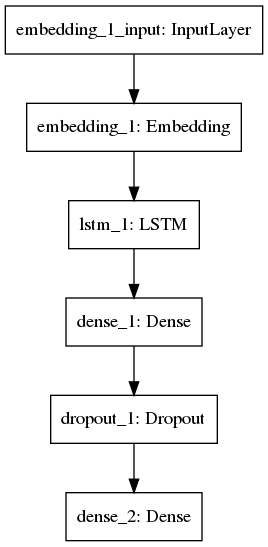

In [20]:
from plot_model import plot_model
tf.keras.utils.plot_model(model, "lstm_glove.png")

In [18]:
# Compile the model
tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks list
filepath = 'rnn_improved_270321.hdf5'
callbacks_list = [ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]

# Train model
batch_size = 512
epochs = 20

with tf.device('/device:GPU:3'):
    history = model.fit(X_train_seq_padded, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val_seq_padded, y_val), verbose=1, callbacks=callbacks_list)

Epoch 1/20
7546/7546 [==============================] - 218s 29ms/step - loss: 0.5127 - accuracy: 0.7653 - val_loss: 0.4884 - val_accuracy: 0.7738

Epoch 00001: val_loss improved from inf to 0.48839, saving model to rnn_improved_270321.hdf5
Epoch 2/20
7546/7546 [==============================] - 215s 29ms/step - loss: 0.4912 - accuracy: 0.7782 - val_loss: 0.4817 - val_accuracy: 0.7792

Epoch 00002: val_loss improved from 0.48839 to 0.48171, saving model to rnn_improved_270321.hdf5
Epoch 3/20
7546/7546 [==============================] - 215s 29ms/step - loss: 0.4831 - accuracy: 0.7821 - val_loss: 0.4769 - val_accuracy: 0.7824

Epoch 00003: val_loss improved from 0.48171 to 0.47687, saving model to rnn_improved_270321.hdf5
Epoch 4/20
7546/7546 [==============================] - 215s 28ms/step - loss: 0.4775 - accuracy: 0.7859 - val_loss: 0.4745 - val_accuracy: 0.7843

Epoch 00004: val_loss improved from 0.47687 to 0.47451, saving model to rnn_improved_270321.hdf5
Epoch 5/20
7546/7546 [==

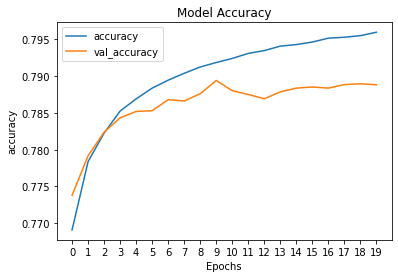

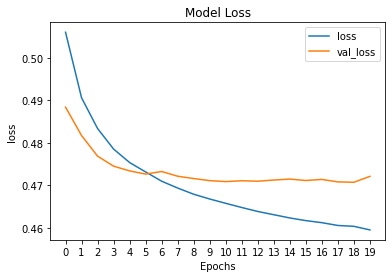

In [19]:
plot_graphs(history, 'accuracy', 'Model Accuracy',20)
plot_graphs(history, 'loss', 'Model Loss',20)

In [2]:
model = load_model('rnn_improved_260321.hdf5', compile=False)

tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7546/7546 [==============================] - 108s 14ms/step - loss: 0.4314 - accuracy: 0.8075
Train Accuracy: 0.807
Train Loss: 0.431


In [21]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39422/39422 [==============================] - 125s 3ms/step - loss: 0.4721 - accuracy: 0.7888
Validation Accuracy: 0.789
Validation Loss: 0.472


In [22]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39422/39422 [==============================] - 120s 3ms/step - loss: 0.4678 - accuracy: 0.7904
Test Accuracy: 0.79
Test Loss: 0.468


In [12]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

Accuracy: 0.793
Precision: 0.8
Recall: 0.691
F-Measure: 0.741


In [13]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     22458
           1       0.80      0.69      0.74     16931

    accuracy                           0.79     39389
   macro avg       0.79      0.78      0.78     39389
weighted avg       0.79      0.79      0.79     39389



Text(0.5, 1, 'Confusion Matrix')

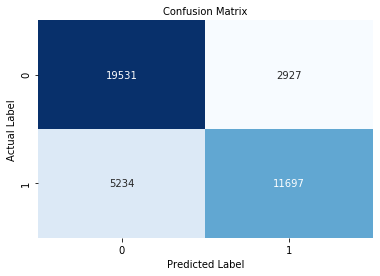

In [14]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

In [21]:
X_test.head()

3146389                        executive director long term care health care system ready
358557                                      office early day video production interesting
2475460                                                           bankruptcy bill pay url
2127236                                 fitness real van back full fitness url good stuff
689196     retweet usermention interesting alibi status update save teen jail retweet url
Name: Text, dtype: object

In [22]:
y_pred[0:5]

array([[1],
       [1],
       [1],
       [0],
       [0]], dtype=int32)

In [23]:
y_test[0:5]

array([1, 0, 1, 0, 0])

In [24]:
df_list = list(X_test.values)
df = pd.DataFrame(df_list, columns=["text"])
df["actual"] = y_test
df["predicted"] = y_pred

incorrect = df[df["actual"] != df["predicted"]]

In [25]:
incorrect

,text,actual,predicted
1,office early day video production interesting,0,1
11,every winter year vowed spend shut cabin fever day art bread url,1,0
16,kelly place like home url,0,1
18,wow checked forever everyone show amazing got josh golden,1,0
19,secret successful organization everyone involved politics involved setting url,0,1
...,...,...,...
39374,cole word official music video premiere url,0,1
39375,new post nerve well ulnar nerve url,0,1
39380,know someone nice thought friend even care feel,1,0
39382,usermention die,1,0


In [26]:
#export incorrect
incorrect.to_csv('incorrect_transformer_improved_260321.txt', sep='\t', index=False, header=False)

In [27]:
df_list = list(X_test.values)
df1 = pd.DataFrame(df_list, columns=["text"])
df1["actual"] = y_test
df1["predicted"] = y_pred

correct = df1[df1["actual"] == df1["predicted"]]

In [28]:
correct

,text,actual,predicted
0,executive director long term care health care system ready,1,1
2,bankruptcy bill pay url,1,1
3,fitness real van back full fitness url good stuff,0,0
4,retweet usermention interesting alibi status update save teen jail retweet url,0,0
5,usermention sound gross,0,0
...,...,...,...
39383,crazy got abusive number statistic domestic violence men,0,0
39384,good night everybody,0,0
39385,url url,0,0
39386,salon aku tar aku ama retweet usermention,0,0


In [29]:
#export correct
correct.to_csv('correct_transformer_improved_260321.txt', sep='\t', index=False, header=False)